Importing necessary libraries for data analysis and visualization

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings

Step 1: Load the datasets

In this step, we load the train.csv and test.csv datasets and combine them into one data DataFrame. This is important as it allows us to analyze the full set of passenger data.

In [22]:
train = pd.read_csv("C:/Users/denis/OneDrive/Рабочий стол/Python/spbu-python-course-1/project/dataset/train.csv")
test = pd.read_csv("C:/Users/denis/OneDrive/Рабочий стол/Python/spbu-python-course-1/project/dataset/test.csv")

data = pd.concat([train, test], ignore_index=True)

Step 2: Convert columns to categorical data types

Here, we are converting certain columns to categorical data types to save memory and improve processing performance.

In [23]:
data["Survived"] = data["Survived"].astype("category")
data["Pclass"] = data["Pclass"].astype("category")
data["Sex"] = data["Sex"].astype("category")

Step 3: Basic Statistics and Insights

We can check the general statistics of the dataset and get an overview of the data. We also perform some grouping operations to gain more insights.

In [24]:
# Show basic statistics for numerical columns
print(data.describe())

# Show the count of passengers in each class
print(data["Pclass"].value_counts())

# Group by Pclass and Sex to see the average age of passengers
age_stats = data.groupby(["Pclass", "Sex"], observed=False)["Age"].mean()
print(age_stats)

       PassengerId          Age        SibSp        Parch         Fare
count  1309.000000  1046.000000  1309.000000  1309.000000  1308.000000
mean    655.000000    29.881138     0.498854     0.385027    33.295479
std     378.020061    14.413493     1.041658     0.865560    51.758668
min       1.000000     0.170000     0.000000     0.000000     0.000000
25%     328.000000    21.000000     0.000000     0.000000     7.895800
50%     655.000000    28.000000     0.000000     0.000000    14.454200
75%     982.000000    39.000000     1.000000     0.000000    31.275000
max    1309.000000    80.000000     8.000000     9.000000   512.329200
Pclass
3    709
1    323
2    277
Name: count, dtype: int64
Pclass  Sex   
1       female    37.037594
        male      41.029272
2       female    27.499223
        male      30.815380
3       female    22.185329
        male      25.962264
Name: Age, dtype: float64


Step 4: Find the youngest and oldest passengers by class and gender

Here, we identify the youngest and oldest passengers based on their age.

In [25]:
# Find the youngest and oldest passengers by class and gender
youngest = age_stats.idxmin(), age_stats.min()
oldest = age_stats.idxmax(), age_stats.max()

print("The Youngest:", youngest)
print("The oldest:", oldest)

The Youngest: ((np.int64(3), 'female'), np.float64(22.185328947368422))
The oldest: ((np.int64(1), 'male'), np.float64(41.02927152317881))


Step 5: Analyze survivors whose names start with 'K'

In this step, we focus on passengers whose names start with the letter 'K' and find out who paid the most and the least.

In [26]:
# Filter survivors whose names start with 'K' and sort by Fare
survivors_with_k = data[(data["Survived"] == 1) & (data["Name"].str.startswith("K"))]
survivors_with_k_sorted = survivors_with_k.sort_values(by="Fare", ascending=False)

# Display the passenger who paid the most and the least
print("Passenger paid more than all:", survivors_with_k_sorted.iloc[0]["Name"])
print("Passenger paid less than all:", survivors_with_k_sorted.iloc[-1]["Name"])

Passenger paid more than all: Kimball, Mr. Edwin Nelson Jr
Passenger paid less than all: Kelly, Miss. Mary


Step 6: Analyze the number of relatives of survivors

This section calculates the number of relatives (siblings/spouses + parents/children) and finds the maximum value for survivors.

In [27]:
# Create a new column 'Relatives' representing the number of relatives
data["Relatives"] = data["SibSp"] + data["Parch"]

# Find the maximum number of relatives among survivors
max_relatives = data[data["Survived"] == 1]["Relatives"].max()
print("Max relatives:", max_relatives)

Max relatives: 6


Step 7: Analyze Fare based on the presence of Cabin

We analyze how the presence or absence of a cabin affects the fare.

In [28]:
# Calculate average Fare for passengers with and without a cabin
with_cabin = data[data["Cabin"].notna()]["Fare"].mean()
without_cabin = data[data["Cabin"].isna()]["Fare"].mean()

# Calculate ratio of fares
fare_ratio = with_cabin / without_cabin if without_cabin != 0 else float("inf")

print("The average ticket price for passengers with a cabin:", with_cabin)
print("The average ticket price for passengers without a cabin:", without_cabin)
print("How many times do the prices differ:", fare_ratio)

The average ticket price for passengers with a cabin: 81.92899830508475
The average ticket price for passengers without a cabin: 19.132707206317864
How many times do the prices differ: 4.282143526350037


Step 8: Visualize Passenger Distribution by Class

Now, we will visualize the distribution of passengers by class using a bar plot.

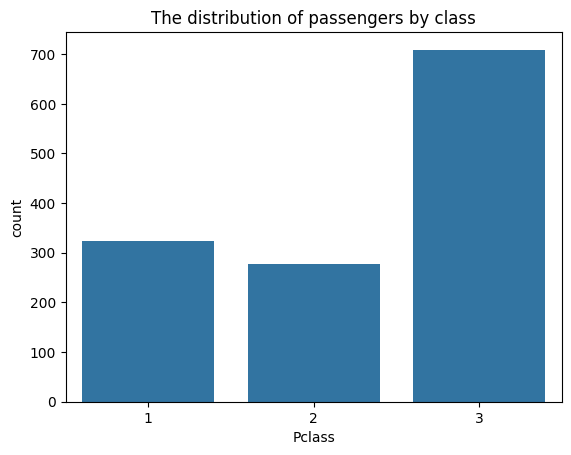

In [29]:
# Visualizing the distribution of passengers by class
sns.countplot(x="Pclass", data=data)
plt.title("The distribution of passengers by class")
plt.show()

Step 9: Create a Sankey Diagram to show the flow of passengers by Class, Sex, and Survival

We will create a Sankey diagram to visualize how passengers flowed through the different categories of Pclass, Sex, and Survived.

In [30]:
# Group by columns and count the number
grouped_data = data.groupby(["Pclass", "Sex", "Survived"]).size()

# Convert Series to DataFrame directly
sankey_data = pd.DataFrame(grouped_data).reset_index()
sankey_data = pd.DataFrame(grouped_data, columns=["Count"]).reset_index()

classes = sorted(data["Pclass"].unique())
sexes = sorted(data["Sex"].unique())
survival_status = ["Did not Survive", "Survived"]

# Create nodes for the Sankey diagram
nodes = {
    **{f"Class {cls}": i for i, cls in enumerate(classes)},
    **{sex: i + len(classes) for i, sex in enumerate(sexes)},
    **{
        status: i + len(classes) + len(sexes)
        for i, status in enumerate(survival_status)
    },
}

# Prepare sources, targets, and values for the Sankey diagram
sources, targets, values = [], [], []

for cls in classes:
    for sex in sexes:
        count = sankey_data[(sankey_data["Pclass"] == cls) & (sankey_data["Sex"] == sex)]["Count"].sum()
        if count > 0:
            sources.append(nodes[f"Class {cls}"])
            targets.append(nodes[sex])
            values.append(count)

for sex in sexes:
    for i, status in enumerate([0, 1]):
        count = sankey_data[(sankey_data["Sex"] == sex) & (sankey_data["Survived"] == status)]["Count"].sum()
        if count > 0:
            sources.append(nodes[sex])
            targets.append(nodes[survival_status[status]])
            values.append(count)

# Create and display the Sankey diagram
fig = go.Figure(
    go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=list(nodes.keys()),
        ),
        link=dict(source=sources, target=targets, value=values),
    )
)
fig.update_layout(title_text="Passenger Flow by Class, Sex, and Survival", font_size=12)
fig.show()

Step 10: Visualize Fare vs Age by Class

We will now create a scatter plot to visualize the relationship between Age and Fare, with the size of the points representing the number of relatives.

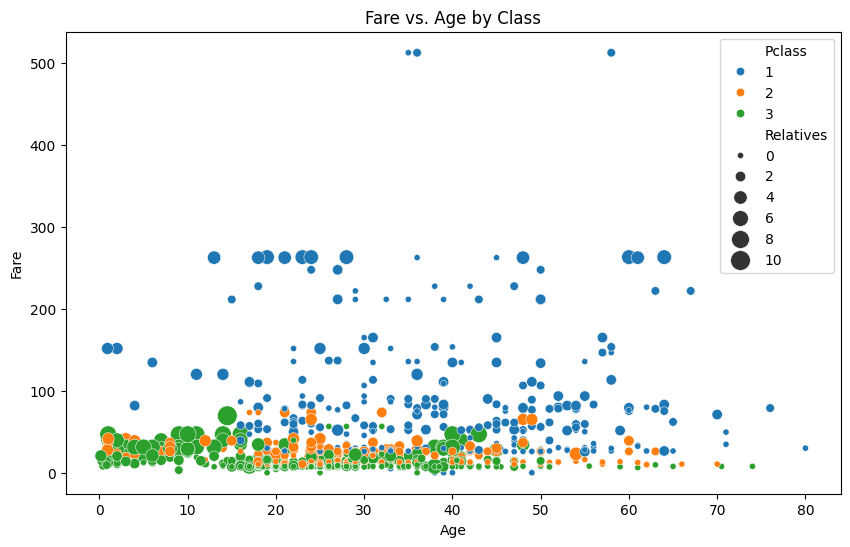

In [31]:
# Visualizing Fare vs Age by Class with the size of the points representing number of relatives
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="Age", y="Fare", hue="Pclass", size="Relatives", sizes=(20, 200))
plt.title("Fare vs. Age by Class")
plt.xlabel("Age")
plt.ylabel("Fare")
plt.show()

Step 11: Analyze Survival by Age

We will analyze the number of survivors and non-survivors by age. This analysis helps us understand how survival rates vary across different age groups.

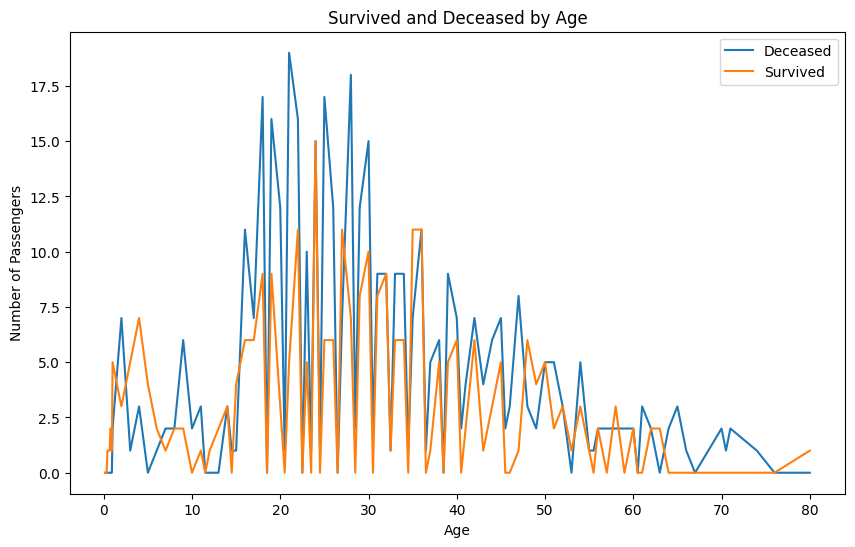

In [32]:
age_survival = data.groupby(["Age", "Survived"], observed=False).size().unstack().fillna(0)
age_survival.plot(figsize=(10, 6), title="Survived and Deceased by Age")
plt.xlabel("Age")
plt.ylabel("Number of Passengers")
plt.legend(["Deceased", "Survived"])
plt.show()

Step 12: Visualize Age Distribution of Passengers

Next, we will create a histogram to visualize the age distribution of passengers. This visualization provides insights into the demographics of the passengers on board.

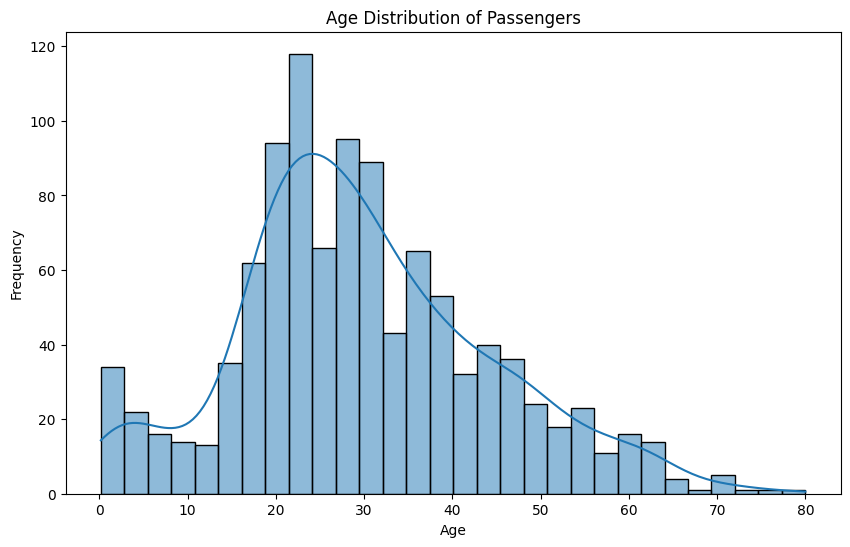

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="Age", bins=30, kde=True)
plt.title("Age Distribution of Passengers")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

Step 13: Visualize Passenger Count by Class

We will create another count plot to visualize the total number of passengers in each class. This helps us understand class distribution among the passengers.

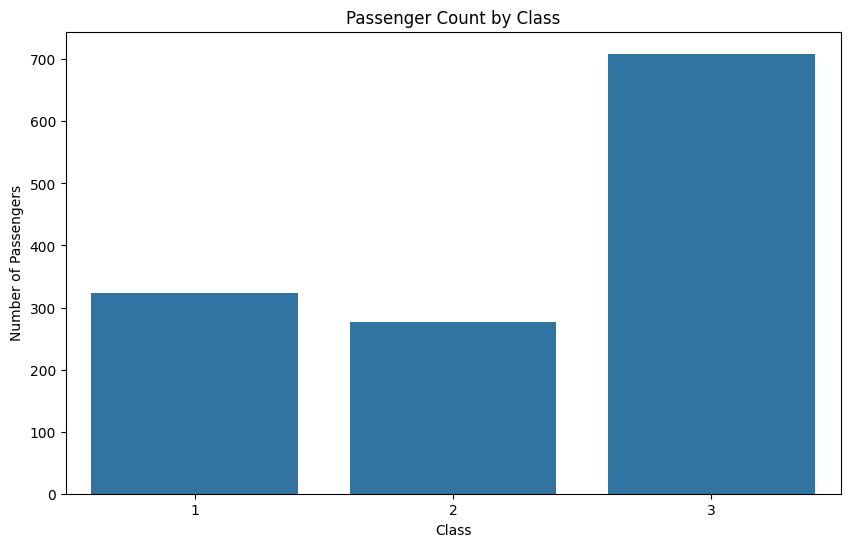

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="Pclass")
plt.title("Passenger Count by Class")
plt.xlabel("Class")
plt.ylabel("Number of Passengers")
plt.show()

Step 14: Visualize Passenger Distribution by Gender

Next, we will visualize the distribution of passengers by gender using a count plot. This will help us see how many male and female passengers were on board.
python

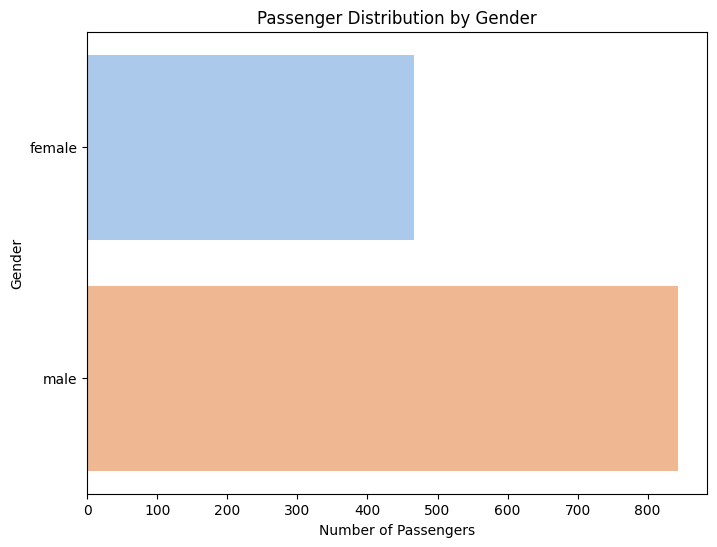

In [35]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, y="Sex", hue="Sex", palette="pastel", legend=False)
plt.title("Passenger Distribution by Gender")
plt.xlabel("Number of Passengers")
plt.ylabel("Gender")
plt.show()

Step 15: Visualize Survival Rate of Passengers

We will create a pie chart to visualize the survival rate of passengers. This provides a clear representation of the proportion of survivors versus non-survivors.

In [36]:
import plotly.express as px

survival_counts = data["Survived"].value_counts()
fig = px.pie(names=survival_counts.index, values=survival_counts.values,
              title="Survival Rate of Passengers")
fig.show()

Step 16: Visualize Fare Distribution by Class

We will create a box plot to visualize the fare distribution across different classes. This helps us understand how fares vary among different passenger classes.

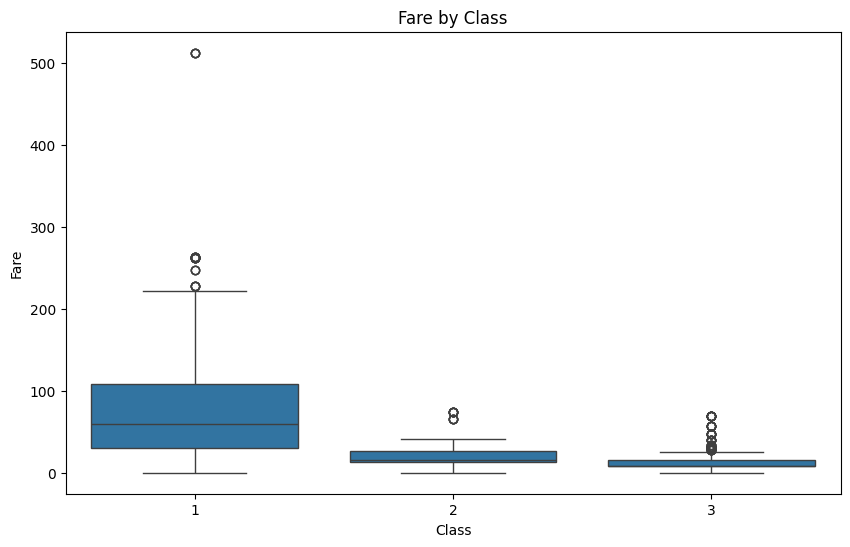

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x="Pclass", y="Fare")
plt.title("Fare by Class")
plt.xlabel("Class")
plt.ylabel("Fare")
plt.show()

Step 17: Visualize Passenger Distribution by Class and Gender

Next, we will use a sunburst chart to visualize the distribution of passengers based on class and gender. This hierarchical visualization provides insights into how different groups are represented.
python

In [38]:
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)


fig = px.sunburst(data,
                  path=["Pclass", "Sex"],
                  values="Fare",
                  title="Passenger Distribution by Class and Gender")
fig.show()

Step 18: Create a 3D Scatter Plot of Age, Relatives, and Fare

We will create a 3D scatter plot to visualize the relationship between Age, Number of Relatives, and Fare. This visualization allows us to explore how these three variables interact with each other.
python

In [39]:
data["Fare"] = data["Fare"].fillna(0)  # Fill NaN values in Fare for plotting
fig = px.scatter_3d(data,
                     x="Age",
                     y="Relatives",
                     z="Fare",
                     color="Pclass",
                     size="Fare",
                     title="3D Scatter Plot of Age, Relatives, and Fare")
fig.show()

Step 19: Visualize Fare vs Age with Survival Status

Finally, we will create a scatter plot to visualize the relationship between Age and Fare while indicating survival status and gender. This visualization helps us see how fare varies with age for survivors and non-survivors.
python

In [40]:
fig = px.scatter(data,
                 x="Age",
                 y="Fare",
                 color="Survived",
                 symbol="Sex",
                 size="Fare",
                 title="Fare vs. Age with Survival Status")
fig.show()